In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns
sns.set_style("darkgrid")
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import re, string, nltk
#import emoji, bz2
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv('/processed_reviews_split_surnamesN_minimal.csv')
df.head()


,review_id,text,verified,review_score,product_category
0,product_review_000000,I purchased this game thinking it would be a r...,True,3,video_games
1,product_review_000001,"It's Light, Bright, and does the trick.. Great...",True,5,musical_instruments
2,product_review_000002,I bought this pedal to get the evh tones of th...,False,5,musical_instruments
3,product_review_000003,I have and use many of Logitech's game control...,False,5,video_games
4,product_review_000004,You have everything to keep you busy for month...,False,5,video_games


In [8]:
df.shape

(32917, 5)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32917 entries, 0 to 32916
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         32917 non-null  object
 1   text              32905 non-null  object
 2   verified          32796 non-null  object
 3   review_score      32917 non-null  int64 
 4   product_category  32011 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


In [10]:
df.isna().sum()

review_id             0
text                 12
verified            121
review_score          0
product_category    906
dtype: int64

In [11]:
df.isnull().sum()

review_id             0
text                 12
verified            121
review_score          0
product_category    906
dtype: int64

In [12]:
import seaborn as sns

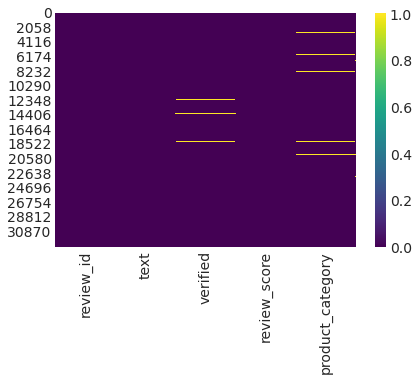

In [ ]:
sns.heatmap(df.isnull(), cmap = 'viridis')

In [14]:
df.product_category.isnull().sum()

906

In [15]:
df.isna().sum()

review_id             0
text                 12
verified            121
review_score          0
product_category    906
dtype: int64

In [16]:
df.product_category.value_counts()

video_games            21821
musical_instruments    10190
Name: product_category, dtype: int64

In [17]:
df.verified.value_counts()

True     23295
False     9501
Name: verified, dtype: int64

In [18]:
df.shape[0] - df.text.isna().sum()


32905

In [19]:
df.text[-5:]

32912    As a beginner I didn't know which pick to chos...
32913                                           nice toy. 
32914    Analogman knows his stuff and helped with the ...
32915    Let's be honest: we all knew it was coming, bu...
32916    Good quality, well built. Good for home, perha...
Name: text, dtype: object

In [20]:
nans = np.where(df.text.isnull() == True)[0]
nans

array([ 6314,  9048, 11865, 12134, 12227, 20471, 21166, 23445, 25727,
       26364, 29321, 30945])

In [21]:
df.isna().sum()

review_id             0
text                 12
verified            121
review_score          0
product_category    906
dtype: int64

In [22]:
df = df[["text","review_score"]]
df

,text,review_score
0,I purchased this game thinking it would be a r...,3
1,"It's Light, Bright, and does the trick.. Great...",5
2,I bought this pedal to get the evh tones of th...,5
3,I have and use many of Logitech's game control...,5
4,You have everything to keep you busy for month...,5
...,...,...
32912,As a beginner I didn't know which pick to chos...,5
32913,nice toy.,3
32914,Analogman knows his stuff and helped with the ...,5
32915,"Let's be honest: we all knew it was coming, bu...",5


In [23]:
df.drop(nans, axis = 0, inplace = True)

In [24]:
df.isnull().sum()

text            0
review_score    0
dtype: int64

In [25]:
np.where(df.text.duplicated() == True)[0]

array([  683,   801,  1094, ..., 32896, 32898, 32900])

In [26]:
df.review_score.unique()

array([ 3,  5,  2,  1,  4, -1])

In [27]:
df.drop(df.loc[df['review_score']==-1].index, inplace=True)

In [28]:
df.review_score.unique()

array([3, 5, 2, 1, 4])

In [29]:
df.duplicated().sum()

1825

In [30]:
df.drop_duplicates(keep = 'first', inplace = True)

In [31]:
df.duplicated().sum()

0

In [32]:
df1 = df
df1.shape

(30175, 2)

In [33]:
df1.review_score.value_counts()

5    18170
4     5839
3     2953
1     1752
2     1461
Name: review_score, dtype: int64

In [34]:
df.columns
#df.product_category.value_counts()

Index(['text', 'review_score'], dtype='object')

In [35]:
def clean_text(df, field):
    df[field] = df[field].str.replace(r"@"," at ")
    df[field] = df[field].str.replace("#[^a-zA-Z0-9_]+"," ")
    df[field] = df[field].str.replace(r"[^a-zA-Z(),\"'\n_]"," ")
    df[field] = df[field].str.replace(r"http\S+","")
    df[field] = df[field].str.lower()
    return df

clean_text(df1,"text")

,text,review_score
0,i purchased this game thinking it would be a r...,3
1,"it's light, bright, and does the trick great...",5
2,i bought this pedal to get the evh tones of th...,5
3,i have and use many of logitech's game control...,5
4,you have everything to keep you busy for month...,5
...,...,...
32912,as a beginner i didn't know which pick to chos...,5
32913,nice toy,3
32914,analogman knows his stuff and helped with the ...,5
32915,"let's be honest we all knew it was coming, bu...",5


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression

from collections import Counter
import nltk
import seaborn as sns
import string
from nltk.corpus import stopwords

import os
#print(os.listdir("../input"))

In [37]:
#pip install emoji
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [38]:
pip install emoji

     |████████████████████████████████| 175 kB 6.7 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=585547aa622545966a384284bca474d0daeaf89879108756a316c1d10861f636
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


This took 11 minutes

In [39]:
import emoji
# Applying Lemmmatizer to remove tenses from texts.
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub('[^a-zA-Z0-9]',' ',text)
    text= re.sub(emoji.get_emoji_regexp(),"",text)
    text = [lemmatizer.lemmatize(word) for word in text.split() if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

df1["clean_text"] = df1["text"].apply(preprocess_text)

In [40]:
df1.head()

,text,review_score,clean_text
0,i purchased this game thinking it would be a r...,3,purchased game thinking would really good part...
1,"it's light, bright, and does the trick great...",5,light bright trick great product price
2,i bought this pedal to get the evh tones of th...,5,bought pedal get evh tone early van halen albu...
3,i have and use many of logitech's game control...,5,use many logitech game controller best used ma...
4,you have everything to keep you busy for month...,5,everything keep busy month maybe year cd inclu...


Text(0, 0.5, 'Text Length')

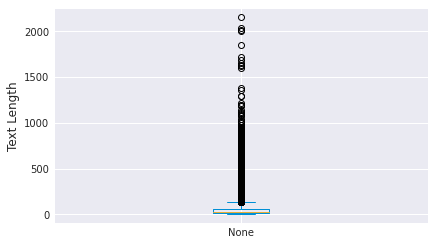

In [41]:
text_length = pd.Series([len(review.split()) for review in df1["clean_text"]])
text_length.plot(kind="box")
plt.ylabel("Text Length")

In [44]:
text_length.describe()

count    30175.000000
mean        59.275460
std        104.292171
min          0.000000
25%         11.000000
50%         24.000000
75%         62.000000
max       2159.000000
dtype: float64

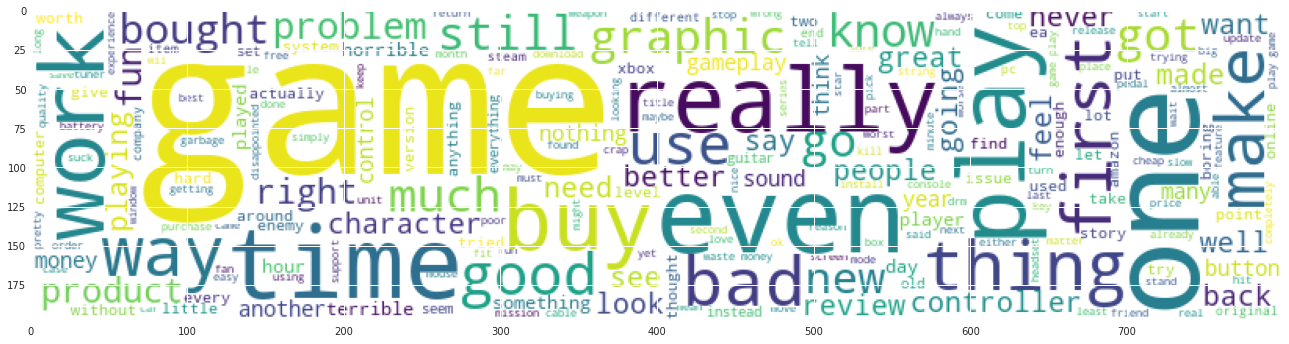

In [45]:
# Negative Review WordCloud
plt.figure(figsize=(20,20))
wc1 = WordCloud(max_words=2000,min_font_size=6, height=200, width=800, 
               background_color="white").generate(" ".join(df1[df1["review_score"]==1].clean_text))
plt.imshow(wc1)

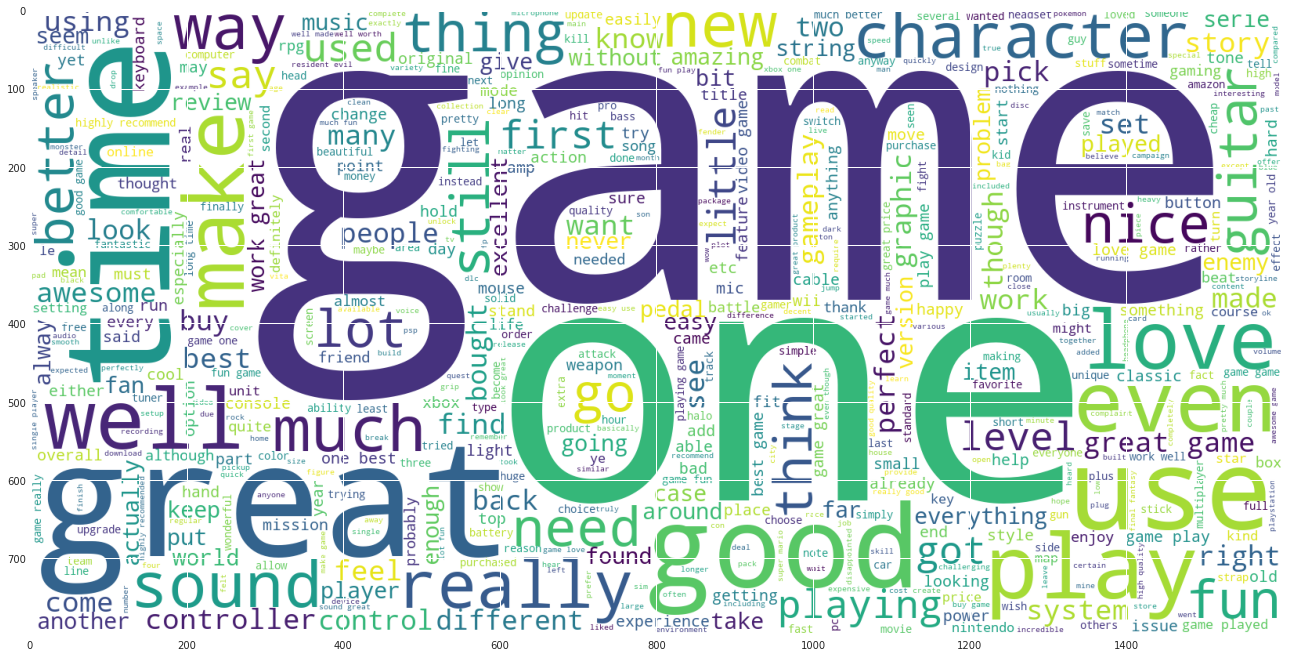

In [46]:
# Positive Review WordCloud
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2000,min_font_size=10, height=800, width=1600, 
               background_color="white").generate(" ".join(df1[df1["review_score"]==5].clean_text))
plt.imshow(wc)

In [47]:
df = df1[["review_score","clean_text"]]
df.head(10)

,review_score,clean_text
0,3,purchased game thinking would really good part...
1,5,light bright trick great product price
2,5,bought pedal get evh tone early van halen albu...
3,5,use many logitech game controller best used ma...
4,5,everything keep busy month maybe year cd inclu...
5,2,case
6,3,main character name vanessa start desert event...
7,5,excellent well worth money better original
8,1,let get right thq made game american fighting ...
9,5,nice string tried yet worth money sure buy ano...


In [48]:
len(df.clean_text), len(df.review_score)

(30175, 30175)

In [49]:
X_train, X_rest, y_train, y_rest = train_test_split(np.array(df["clean_text"]),np.array(df["review_score"]), test_size=0.05,random_state=49)
print(X_train.shape)
print(X_rest.shape)

(28666,)
(1509,)


In [50]:
X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size = 0.5, random_state = 49)
X_test.shape, X_valid.shape

((755,), (754,))

In [51]:
X_train[0]

'pet oh sure get fish guini pig without unleashed want interesting pet get expansion unleashed give dog cat bird turtle iguana many different breed dog cat different type bird dog cat become part family get run house even though able open door canine feline pet give lonely sims social time prevent le outgoing sims getting depressed unfortunatly make dog cat eat sleep play command stop drinking toilet relieving carpet neighborhood unleashed expansion total lot also cool option making community lot build restaurant market pet shop place sims socialize really cool budget worry another nice addition build house sim move half fun sims building house bonus sims live land tending garden harvest choose put vegetable pantry later sell market unleashed great addition sims anyone enjoys sims definately pick one best sims expansion pack'

In [52]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf2 = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize)
X_train_tf2 = tfidf2.fit_transform(X_train)
X_valid_tf2 = tfidf2.transform(X_valid)
X_test_tf2 = tfidf2.transform(X_test)

In [54]:
X_train_tf2.shape, X_valid_tf2.shape, X_test_tf2.shape

((28666, 40989), (754, 40989), (755, 40989))

In [55]:
X_train_tf2[0], X_valid_tf2[0], X_test_tf2[0]

(<1x40989 sparse matrix of type '<class 'numpy.float64'>'
 	with 99 stored elements in Compressed Sparse Row format>,
 <1x40989 sparse matrix of type '<class 'numpy.float64'>'
 	with 33 stored elements in Compressed Sparse Row format>,
 <1x40989 sparse matrix of type '<class 'numpy.float64'>'
 	with 10 stored elements in Compressed Sparse Row format>)

In [56]:
y_train = np.asarray(y_train).astype('float32')
y_valid = np.asarray(y_valid).astype('float32')
y_test = np.asarray(y_test).astype('float32')
print("y_train ", y_train.shape)
print("y_valid ", y_valid.shape)
print("y_test ", y_test.shape)

y_train  (28666,)
y_valid  (754,)
y_test  (755,)


In [57]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [58]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [59]:
X_train_seq_padded = pad_sequences(X_train_seq)
X_valid_seq_padded = pad_sequences(X_valid_seq)
X_test_seq_padded = pad_sequences(X_test_seq)

In [60]:
np.set_printoptions(threshold=np.inf)

In [61]:
X_train_seq_padded.shape, X_valid_seq_padded.shape, X_test_seq_padded.shape

((28666, 2159), (754, 1276), (755, 1138))

In [62]:
from sklearn.metrics import accuracy_score, classification_report

In [63]:
from sklearn.neighbors import KNeighborsClassifier

In [64]:
from pandas.core.common import random_state
for i in range(2, 12, 2):
  neigh = KNeighborsClassifier(n_neighbors=i)
  neigh.fit(X_train_tf2, y_train)
  k_pred = neigh.predict(X_valid_tf2)
  print(accuracy_score(k_pred, y_valid))

0.2413793103448276
0.553050397877984
0.5769230769230769
0.5795755968169761
0.5769230769230769


In [65]:
neigh = KNeighborsClassifier(n_neighbors = 32, algorithm = 'auto', p = 2)

In [66]:
neigh.fit(X_train_tf2, y_train)

KNeighborsClassifier(n_neighbors=32)

In [67]:
k_pred = neigh.predict(X_valid_tf2)

In [68]:
k_pred1 = neigh.predict(X_train_tf2)

In [69]:
accuracy_score(k_pred1, y_train)

0.6061187469476035

In [70]:
accuracy_score(k_pred, y_valid)

0.5888594164456233

In [71]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
naive = MultinomialNB()
naive.fit(X_train_tf2, y_train)

MultinomialNB()

In [72]:
naive1 = BernoulliNB()
naive1.fit(X_train_tf2, y_train)

BernoulliNB()

In [73]:
naive2 = ComplementNB()
naive2.fit(X_train_tf2, y_train)

ComplementNB()

In [74]:
n_pred = naive.predict(X_valid_tf2)

In [75]:
n_pred1 = naive1.predict(X_valid_tf2)

In [76]:
n_pred2 = naive2.predict(X_valid_tf2)

In [77]:
accuracy_score(n_pred, y_valid)

0.5875331564986738

In [78]:
accuracy_score(n_pred1, y_valid)

0.5610079575596817

In [79]:
accuracy_score(n_pred2, y_valid)

0.6220159151193634

In [80]:
print(classification_report(k_pred, y_valid))

              precision    recall  f1-score   support

         1.0       0.02      1.00      0.04         1
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         0
         5.0       1.00      0.59      0.74       751

    accuracy                           0.59       754
   macro avg       0.20      0.32      0.16       754
weighted avg       1.00      0.59      0.74       754



In [81]:
print(classification_report(n_pred2, y_valid))

              precision    recall  f1-score   support

         1.0       0.39      0.77      0.52        26
         2.0       0.06      0.29      0.10         7
         3.0       0.09      0.43      0.15        14
         4.0       0.06      0.27      0.10        37
         5.0       0.97      0.64      0.77       670

    accuracy                           0.62       754
   macro avg       0.32      0.48      0.33       754
weighted avg       0.88      0.62      0.71       754



In [82]:
X_test[0]

'easy apply totally invisible place great keeping screen scratch free'

In [83]:
X_test_tf2[0]

<1x40989 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [86]:
naive2.predict(X_test_tf2[0])

array([5.], dtype=float32)

In [87]:
X_test[1]

'cant beat money setup want stop paying pesky luthier every time weather change buy thing cant beat money'

In [88]:
naive2.predict(X_test_tf2[1])

array([5.], dtype=float32)

In [89]:
X_test[2]

'build quality form design good big fan black lime green built speaker also fine capable pretty loud sound top feel key fine say spring medium firmness white key push pretty nice amount travel black key press also feel appropriate velocity sensing dynamic expect keyboard category price nice selection built sound covering lot different timbre instrument toy sound decent toy bit sound think old atari game like bit hear lo fi grit tolerable also kind interesting selection drum beat standard kind quirky like diversity rhythm sound included con tempo option scaled weird somewhat useless way drum beat tempo setting bpm beat per minute upper tempo ridiculous bpm pretty impressive range however giant gap setting especially bottom end could picked useful range selection tempo especially kid learning song need right tempo example transpose though tuning function transpose function would useful able drop key octave two sound would nice play lower octave bought home music studio sometimes need qui

In [90]:
naive2.predict(X_test_tf2[2])

array([5.], dtype=float32)

In [91]:
X_test[13]

'instruction included cheaply made dud work company defunct website fit usa fender strat hole align large degree enlarged spacing rotary tool cursing lot got thing fraud effect whatever holding pitch string bending another matter set look trem block bending string move always buy p played guitar year messed strats countless time dud'

In [92]:
naive2.predict(X_test_tf2[13])

array([5.], dtype=float32)

In [93]:
X_test[57]

'pro audio pretty pricey getting quality mixer sound card cost hundred tried using low cost phantom power unit along xlr adapter produced poor result phantom power caused interference pattern line line produced lot white noise decided get work basic mixer amp performs well require much fooling get working whatever reason creates jack mic stereo default window try send sound usb stereo jack nothing disabled device simple switch pick amplification level high low medium use high least background noise turn input bit pc add light digital noise filter cut background static end result quite acceptable mic using cheap unit allows perform well build quality ok best little nut end get loose tightened kind fall apart pcb held place tiny screw clamp main board held place well also switch low med high flimsy plan leaving set one mode touching fine good low cost alternative'

In [94]:
naive2.predict(X_test_tf2[57])

array([5.], dtype=float32)

#### Project 2


In [95]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns
sns.set_style("darkgrid")
#from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import re, string, nltk
#import emoji, bz2
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [97]:
Data = pd.read_csv('/processed_reviews_split_surnamesN_minimal.csv')
Data.head()

,review_id,text,verified,review_score,product_category
0,product_review_000000,I purchased this game thinking it would be a r...,True,3,video_games
1,product_review_000001,"It's Light, Bright, and does the trick.. Great...",True,5,musical_instruments
2,product_review_000002,I bought this pedal to get the evh tones of th...,False,5,musical_instruments
3,product_review_000003,I have and use many of Logitech's game control...,False,5,video_games
4,product_review_000004,You have everything to keep you busy for month...,False,5,video_games


In [98]:
Data.shape

(32917, 5)

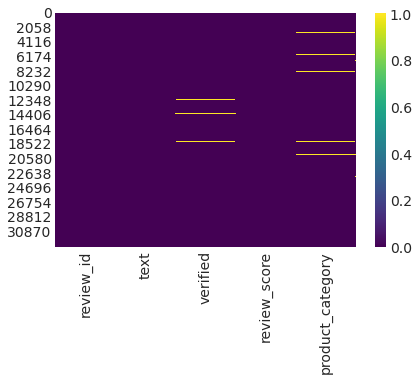

In [99]:
import seaborn as sns
sns.heatmap(Data.isnull(), cmap = 'viridis')

In [100]:
Data.product_category.isnull().sum()

906

In [101]:
nulls = np.where(Data.product_category.isnull())[0]

In [102]:
nulls

array([   26,    78,    88,   113,   151,   201,   258,   333,   449,
         463,   484,   514,   517,   542,   597,   671,   715,   784,
         786,   899,   938,   975,  1032,  1033,  1377,  1411,  1417,
        1452,  1457,  1474,  1476,  1523,  1565,  1571,  1639,  1652,
        1707,  1765,  1768,  1889,  1891,  1934,  1936,  1990,  1998,
        2035,  2052,  2086,  2108,  2125,  2126,  2159,  2205,  2263,
        2339,  2488,  2516,  2551,  2571,  2586,  2596,  2601,  2602,
        2613,  2618,  2717,  2766,  2868,  2899,  2910,  2969,  3003,
        3087,  3094,  3181,  3205,  3209,  3236,  3238,  3262,  3266,
        3287,  3317,  3402,  3429,  3528,  3604,  3626,  3682,  3702,
        3706,  3717,  3749,  3769,  3782,  3812,  3844,  3911,  4010,
        4019,  4049,  4099,  4154,  4203,  4209,  4261,  4305,  4369,
        4400,  4455,  4535,  4598,  4623,  4624,  4625,  4671,  4682,
        4777,  4827,  4860,  4931,  4953,  5015,  5024,  5101,  5136,
        5151,  5163,

In [103]:
Data.drop(nulls, axis = 0, inplace = True)

In [104]:
Data.shape

(32011, 5)

In [105]:
Data.product_category.isnull().sum()

0

In [106]:
Data.text.isna().sum()

12

In [107]:
Data.shape

(32011, 5)

In [108]:
Data.head(10)

,review_id,text,verified,review_score,product_category
0,product_review_000000,I purchased this game thinking it would be a r...,True,3,video_games
1,product_review_000001,"It's Light, Bright, and does the trick.. Great...",True,5,musical_instruments
2,product_review_000002,I bought this pedal to get the evh tones of th...,False,5,musical_instruments
3,product_review_000003,I have and use many of Logitech's game control...,False,5,video_games
4,product_review_000004,You have everything to keep you busy for month...,False,5,video_games
5,product_review_000005,no case.,True,2,video_games
6,product_review_000006,The main character's name is Vanessa.\n\nYou s...,False,3,video_games
7,product_review_000007,"Excellent well worth the money, better than th...",True,5,video_games
8,product_review_000008,So let me get this right? THQ made a game wher...,False,1,video_games
9,product_review_000009,"Nice strings, have not tried the A yet, but th...",True,5,musical_instruments


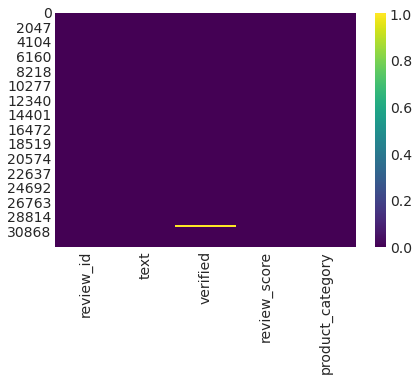

In [109]:
sns.heatmap(Data.isnull(), cmap = 'viridis')

In [110]:
Data = Data[['text', 'product_category']]
Data.head()

,text,product_category
0,I purchased this game thinking it would be a r...,video_games
1,"It's Light, Bright, and does the trick.. Great...",musical_instruments
2,I bought this pedal to get the evh tones of th...,musical_instruments
3,I have and use many of Logitech's game control...,video_games
4,You have everything to keep you busy for month...,video_games


In [111]:
Data.product_category.unique()

array(['video_games', 'musical_instruments'], dtype=object)

In [114]:
Data3 = Data.replace('video_games', 0)

In [115]:
Data = Data3.replace('musical_instruments', 1)

In [116]:
Data

,text,product_category
0,I purchased this game thinking it would be a r...,0
1,"It's Light, Bright, and does the trick.. Great...",1
2,I bought this pedal to get the evh tones of th...,1
3,I have and use many of Logitech's game control...,0
4,You have everything to keep you busy for month...,0
...,...,...
32912,As a beginner I didn't know which pick to chos...,1
32913,nice toy.,1
32914,Analogman knows his stuff and helped with the ...,1
32915,"Let's be honest: we all knew it was coming, bu...",0


In [117]:
Data.duplicated().sum()

1838

In [118]:
Data.drop_duplicates(keep = 'first', inplace = True)

In [119]:
Data.duplicated().sum()

0

In [120]:
Data.shape

(30173, 2)

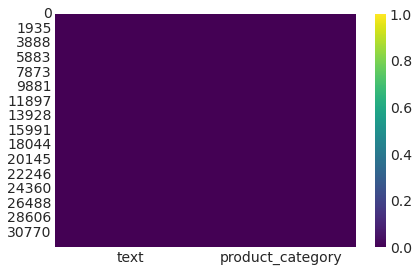

In [121]:
sns.heatmap(Data.isnull(), cmap = 'viridis')

In [122]:
def clean_text(df, field):
    df[field] = df[field].str.replace(r"@"," at ")
    df[field] = df[field].str.replace("#[^a-zA-Z0-9_]+"," ")
    df[field] = df[field].str.replace(r"[^a-zA-Z(),\"'\n_]"," ")
    df[field] = df[field].str.replace(r"http\S+","")
    df[field] = df[field].str.lower()
    return df

clean_text(Data,"text")

,text,product_category
0,i purchased this game thinking it would be a r...,0
1,"it's light, bright, and does the trick great...",1
2,i bought this pedal to get the evh tones of th...,1
3,i have and use many of logitech's game control...,0
4,you have everything to keep you busy for month...,0
...,...,...
32911,"works fine for me, metal and looks good althou...",1
32913,nice toy,1
32914,analogman knows his stuff and helped with the ...,1
32915,"let's be honest we all knew it was coming, bu...",0


In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression

from collections import Counter
import nltk
import seaborn as sns
import string
from nltk.corpus import stopwords

import os
#print(os.listdir("../input"))

In [124]:
#pip install emoji
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [125]:
pip install emoji

In [126]:
import emoji
# Applying Lemmmatizer to remove tenses from texts.
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r"won\'t", "will not", str(text))
    text = re.sub(r"can\'t", "can not", str(text))
    text = re.sub('[^a-zA-Z0-9]',' ',str(text))
    text= re.sub(emoji.get_emoji_regexp(),"",str(text))
    text = [lemmatizer.lemmatize(word) for word in text.split() if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text


In [127]:
Data.head()

,text,product_category
0,i purchased this game thinking it would be a r...,0
1,"it's light, bright, and does the trick great...",1
2,i bought this pedal to get the evh tones of th...,1
3,i have and use many of logitech's game control...,0
4,you have everything to keep you busy for month...,0


In [128]:
Data['cleaned_text'] = Data.text.apply(preprocess_text)

In [129]:
Data

,text,product_category,cleaned_text
0,i purchased this game thinking it would be a r...,0,purchased game thinking would really good part...
1,"it's light, bright, and does the trick great...",1,light bright trick great product price
2,i bought this pedal to get the evh tones of th...,1,bought pedal get evh tone early van halen albu...
3,i have and use many of logitech's game control...,0,use many logitech game controller best used ma...
4,you have everything to keep you busy for month...,0,everything keep busy month maybe year cd inclu...
...,...,...,...
32911,"works fine for me, metal and looks good althou...",1,work fine metal look good although scuff good ...
32913,nice toy,1,nice toy
32914,analogman knows his stuff and helped with the ...,1,analogman know stuff helped design genuine jrc...
32915,"let's be honest we all knew it was coming, bu...",0,let honest knew coming know still expect heard...


In [130]:
Data_ct = Data[['product_category', 'cleaned_text']]
Data_ct

,product_category,cleaned_text
0,0,purchased game thinking would really good part...
1,1,light bright trick great product price
2,1,bought pedal get evh tone early van halen albu...
3,0,use many logitech game controller best used ma...
4,0,everything keep busy month maybe year cd inclu...
...,...,...
32911,1,work fine metal look good although scuff good ...
32913,1,nice toy
32914,1,analogman know stuff helped design genuine jrc...
32915,0,let honest knew coming know still expect heard...


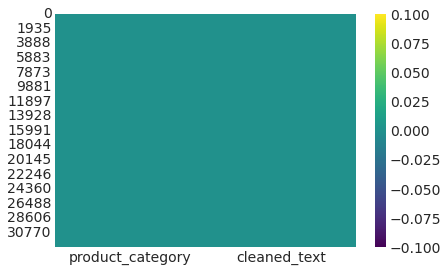

In [131]:
sns.heatmap(Data_ct.isnull(), cmap = 'viridis')

In [132]:
X_train2, X_rest2, y_train2, y_rest2 = train_test_split(np.array(Data_ct["cleaned_text"]),np.array(Data_ct["product_category"]), test_size=0.05,random_state=49)
print(X_train2.shape)
print(X_rest2.shape)

(28664,)
(1509,)


In [133]:
X_valid2, X_test2, y_valid2, y_test2 = train_test_split(X_rest2, y_rest2, test_size = 0.5, random_state = 49)
X_test2.shape, X_valid2.shape

((755,), (754,))

In [134]:
X_train2[0], X_valid2[0]

('bought replace current one fender strat fit small avoid using fender fit strat',
 'best mic musician recommend vocal live concert')

In [135]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [136]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf2 = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize)
X_train2_tf2 = tfidf2.fit_transform(X_train2)
X_valid2_tf2 = tfidf2.transform(X_valid2)
X_test2_tf2 = tfidf2.transform(X_test2)

In [137]:
X_train2_tf2.shape, X_valid2_tf2.shape, X_test2_tf2.shape

((28664, 41034), (754, 41034), (755, 41034))

In [138]:
?y_train2 = np.asarray(y_train2).astype('float32')
y_valid2 = np.asarray(y_valid2).astype('float32')
y_test2 = np.asarray(y_test2).astype('float32')
print("y_train ", y_train2.shape)
print("y_valid ", y_valid2.shape)
print("y_test ", y_test2.shape)

y_train  (28664,)
y_valid  (754,)
y_test  (755,)


In [139]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train2)

In [140]:
X_train2_seq = tokenizer.texts_to_sequences(X_train2)
X_valid2_seq = tokenizer.texts_to_sequences(X_valid2)
X_test2_seq = tokenizer.texts_to_sequences(X_test2)

In [141]:
X_train2_seq_padded = pad_sequences(X_train2_seq)
X_valid2_seq_padded = pad_sequences(X_valid2_seq)
X_test2_seq_padded = pad_sequences(X_test2_seq)

In [142]:
np.set_printoptions(threshold=np.inf)

In [143]:
from sklearn.metrics import accuracy_score, classification_report

In [144]:
from sklearn.neighbors import KNeighborsClassifier

In [145]:
for i in range(25, 50, 5):
    neighs = KNeighborsClassifier(n_neighbors=i)
    neighs.fit(X_train2_tf2, y_train2)
    k_pred2 = neighs.predict(X_valid2_tf2)
    print(accuracy_score(k_pred2, y_valid2))

0.8222811671087533
0.8474801061007957
0.8740053050397878
0.8673740053050398
0.8779840848806366


In [146]:
neighs = KNeighborsClassifier(n_neighbors = 33, algorithm = 'auto', p = 2)

In [148]:
neighs.fit(X_train2_tf2, y_train2)

KNeighborsClassifier(n_neighbors=33)

In [149]:
k_pred2 = neighs.predict(X_valid2_tf2)

In [150]:
accuracy_score(k_pred2, y_valid2)

0.8673740053050398

In [151]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
naive = MultinomialNB()
naive.fit(X_train2_tf2, y_train2)

MultinomialNB()

In [152]:
naive1 = BernoulliNB()
naive1.fit(X_train2_tf2, y_train2)

BernoulliNB()

In [153]:
naive2 = ComplementNB()
naive2.fit(X_train2_tf2, y_train2)

ComplementNB()

In [154]:
n_pred = naive.predict(X_valid2_tf2)

In [155]:
n_pred1 = naive1.predict(X_valid2_tf2)

In [156]:
n_pred2 = naive2.predict(X_valid2_tf2)

In [157]:
accuracy_score(n_pred, y_valid2)

0.9111405835543767

In [158]:
accuracy_score(n_pred1, y_valid2)

0.7254641909814323

In [159]:
accuracy_score(n_pred2, y_valid2)

0.9283819628647215

In [160]:
print(classification_report(k_pred2, y_valid2))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91       571
           1       0.66      0.95      0.78       183

    accuracy                           0.87       754
   macro avg       0.82      0.89      0.84       754
weighted avg       0.90      0.87      0.87       754



In [161]:
print(classification_report(n_pred2, y_valid2))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       507
           1       0.87      0.92      0.89       247

    accuracy                           0.93       754
   macro avg       0.91      0.93      0.92       754
weighted avg       0.93      0.93      0.93       754



In [162]:
X_test2[45], y_test2[45]

('pair xbox controller instantly super long cord may place wherever wish great device play pc game xbox controller work great',
 0.0)

In [163]:
naive2.predict(X_test2_tf2[45])

array([0])

In [164]:
X_test2[14], y_test2[14]

('producto nuevo sin uso entregado en fecha comprado buen precio en poca de descuento vendedor serio cumple con lo que ofrece como corresponde gran oferta',
 0.0)

In [165]:
naive2.predict(X_test2_tf2[14])

array([0])

In [166]:
X_test2[243], y_test2[243]

('critical reception bionic commando anything kind p version game sitting gamerankings aggregate score seen game get short shrift never much bionic commando small confession make halfway game enamored wait write review breakdown graphic stunning throughout animation seem realistic considering subject matter least environment breathtaking much say nothing complain story heard aspect take criticism apparently ending love hate enjoying story partly effective voice acting steve blum always put good performance effective super joe familiar va main character certainly good job making believe enjoying swinging much brings u gameplay nothing else market like bc fps even standard rd person shooter main focus effective use bionic arm result compared spider man game comparison leaf nuance bc brings table first level design superb whereas spider man level game typically limited swinging around old skyscraper bc level filled kind broken building suspended railway cavern even mechanic swinging ident

In [167]:
naive2.predict(X_test2_tf2[243])

array([0])

In [168]:
X_test2[564], y_test2[564]

('game marginally better review indicate horrifically repetitive year old love however solid buy kid older expecting something craftsmanship mario game going extremely disappointed p launch game lego marvel far better choice family much longevity fantastic kid everyone else avoid',
 0.0)

In [169]:
naive2.predict(X_test2_tf2[564])

array([0])